In [1]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
nltk.data.path.append('./data')
nltk.download('stopwords', './data/')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to ./data/...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/artkra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
from collections import Counter
c = Counter()


In [9]:
with open('../../data/slack/messages.txt', 'r') as fr:
    with open('../../data/slack/tokens.txt', 'w') as fw:
        for line in fr.readlines():
            if '?' in line:
                tokens = [w.lower() for w in nltk.tokenize.word_tokenize(line) if w.isalpha()]
                tokens = [w for w in tokens if w not in nltk.corpus.stopwords.words('russian')]
                tokens = [w for w in tokens if w not in nltk.corpus.stopwords.words('english')]
                c += Counter(tokens)
                fw.write(','.join(tokens) + '\n')
        


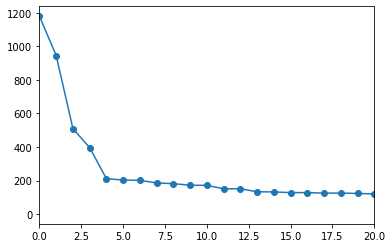

In [10]:
X = []
Y = []
WORDS = []
for i, word in enumerate(sorted(c, key=lambda x: c[x], reverse=True)):
    X.append(i)
    WORDS.append(word)
    Y.append(c[word])
plt.plot(X, Y, marker='o')
plt.xlim([0, 20])
plt.show()

In [11]:
YSHIFTED = copy(Y)
YSHIFTED = YSHIFTED[1::]
YSHIFTED.append(0)

In [12]:
DIFFS = np.array(Y) - np.array(YSHIFTED)

In [13]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [35]:
def get_text():
    with open('../../data/slack/messages.txt', 'r') as fr:
        return fr.read()


def tokenize_text(text):
    def to_include(word):
        if any([
            not word.isalpha(),
            word in nltk.corpus.stopwords.words('russian'),
            word in nltk.corpus.stopwords.words('english')
        ]):
            return False
        return True
    tokens = [w.lower() for w in nltk.tokenize.word_tokenize(text) if to_include(w)]
    return tokens


def count_freq(tokens):
    c = Counter(tokens)
    return sorted(c, key=lambda x: c[x])

In [30]:
TOKENS = tokenize_text(get_text())

In [ ]:
len(Counter(TOKENS))

In [37]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 50

trigrams = [([TOKENS[i], TOKENS[i + 1]], TOKENS[i + 2])
            for i in range(len(TOKENS) - 2)]

vocab = set(TOKENS)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

KeyboardInterrupt: 

In [242]:
nn.PairwiseDistance()(model.embeddings(torch.tensor([word_to_ix['beauty']], dtype=torch.long)),
model.embeddings(torch.tensor([word_to_ix['blood']], dtype=torch.long)))

tensor([11.0422], grad_fn=<NormBackward1>)

In [43]:
torch.save(model, '/home/artkra/SOURCES/faqer/models/pickled/mdl')

In [44]:
trm = torch.load('/home/artkra/SOURCES/faqer/models/pickled/mdl')

In [55]:
trm.embeddings(torch.tensor([word_to_ix['привязки']], dtype=torch.long))

tensor([[-1.1428, -0.0673,  1.4930, -1.7046,  0.0919, -0.5974,  0.2349,  0.1478,
         -1.6745, -0.2391,  1.1290, -0.2519,  1.4631,  0.2526, -0.3291, -0.5784,
          0.4800,  1.2138,  0.7522, -1.3980, -0.0453,  1.3891,  0.2601,  1.3152,
         -0.2578, -0.2474, -1.4981,  0.9320, -2.1634, -0.1619, -0.1663,  0.2423,
         -1.9050,  2.5494,  0.9253,  1.2111, -0.7454,  0.1759,  0.3996, -0.4775,
         -0.2414,  0.6097,  0.9918,  0.7516,  1.3588, -0.0250,  1.0351,  1.1524,
         -0.7486,  0.3798]], grad_fn=<EmbeddingBackward>)

In [56]:
model.embeddings(torch.tensor([word_to_ix['привязки']], dtype=torch.long))

tensor([[-1.1428, -0.0673,  1.4930, -1.7046,  0.0919, -0.5974,  0.2349,  0.1478,
         -1.6745, -0.2391,  1.1290, -0.2519,  1.4631,  0.2526, -0.3291, -0.5784,
          0.4800,  1.2138,  0.7522, -1.3980, -0.0453,  1.3891,  0.2601,  1.3152,
         -0.2578, -0.2474, -1.4981,  0.9320, -2.1634, -0.1619, -0.1663,  0.2423,
         -1.9050,  2.5494,  0.9253,  1.2111, -0.7454,  0.1759,  0.3996, -0.4775,
         -0.2414,  0.6097,  0.9918,  0.7516,  1.3588, -0.0250,  1.0351,  1.1524,
         -0.7486,  0.3798]], grad_fn=<EmbeddingBackward>)